Loading training data...
Extracting time features...
Original dataset - Fraud cases: 7506, Non-fraud cases: 1289169
Training dataset - Fraud cases: 7506, Non-fraud cases: 38000
Loading test data...
Preprocessing data...
Training model on GPU...
Evaluating model...

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.29      0.30      0.29      2145

    accuracy                           0.99    555719
   macro avg       0.64      0.65      0.65    555719
weighted avg       0.99      0.99      0.99    555719



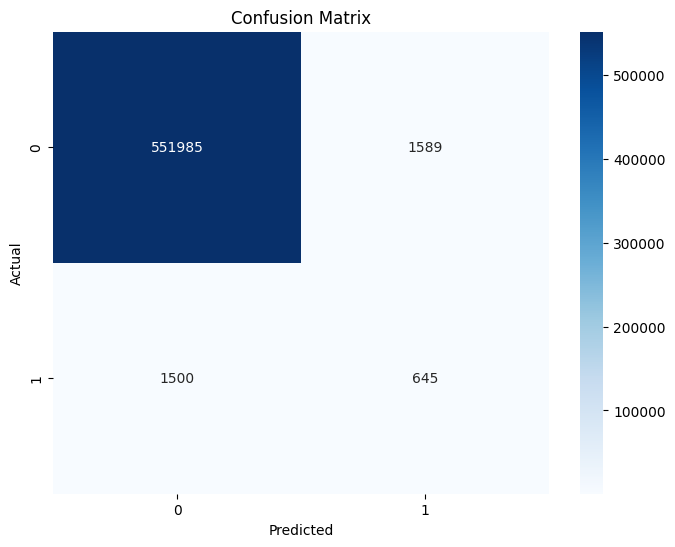

In [57]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from cuml.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from datetime import datetime

class RobustLabelEncoder:
    def __init__(self):
        self.mapping = {}
        self.counter = 0
        
    def fit(self, data):
        unique_values = pd.Series(data).unique()
        for value in unique_values:
            self.mapping[value] = self.counter
            self.counter += 1
        return self
    
    def transform(self, data):
        return pd.Series(data).map(lambda x: self.mapping.get(x, self.counter))
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

def extract_time_features(df):
    """Extract features from transaction timestamp and DOB"""
    # Convert transaction datetime (assuming format like '2019-01-01 00:00:00')
    df['trans_datetime'] = pd.to_datetime(df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')
    
    # Extract transaction time features as numeric values
    df['trans_hour'] = df['trans_datetime'].dt.hour.astype(float)
    df['trans_day'] = df['trans_datetime'].dt.day.astype(float)
    df['trans_month'] = df['trans_datetime'].dt.month.astype(float)
    df['trans_day_of_week'] = df['trans_datetime'].dt.dayofweek.astype(float)
    df['is_weekend'] = df['trans_datetime'].dt.dayofweek.isin([5, 6]).astype(float)
    
    # Convert DOB and calculate age (assuming format like 'YYYY-MM-DD')
    df['dob_datetime'] = pd.to_datetime(df['dob'], format='%Y-%m-%d')
    df['age'] = (df['trans_datetime'] - df['dob_datetime']).dt.days / 365.25
    df['age'] = df['age'].astype(float)
    df['age_decade'] = (df['age'] // 10 * 10).astype(float)
    
    # Drop original datetime columns
    df = df.drop(['trans_datetime', 'dob_datetime', 'trans_date_trans_time', 'dob'], axis=1)
    
    return df

def train_fraud_detection(train_path, test_path=None, fraud_ratio=0.3, sample_size=100000):
    """Train fraud detection model using GPU with improved sampling and time features"""
    print("Loading training data...")
    train_data = pd.read_csv(train_path)
    
    # Remove unnecessary columns but keep DOB and transaction time for feature extraction
    drop_cols = [
        'Unnamed: 0', 'cc_num', 'first', 'last', 'street', 'city', 
        'state', 'zip', 'trans_num'
    ]
    train_data = train_data.drop(columns=[col for col in drop_cols if col in train_data.columns])
    
    # Extract time-based features
    print("Extracting time features...")
    train_data = extract_time_features(train_data)
    
    # Separate fraud and non-fraud cases
    fraud_data = train_data[train_data['is_fraud'] == 1]
    non_fraud_data = train_data[train_data['is_fraud'] == 0]
    
    print(f"Original dataset - Fraud cases: {len(fraud_data)}, Non-fraud cases: {len(non_fraud_data)}")
    
    # Determine sample sizes
    n_fraud = min(len(fraud_data), int(sample_size * fraud_ratio))
    n_non_fraud = min(len(non_fraud_data), int(sample_size * (1 - fraud_ratio)))
    
    # Sample data
    fraud_sampled = fraud_data.sample(n=n_fraud, random_state=42)
    non_fraud_sampled = non_fraud_data.sample(n=n_non_fraud, random_state=42)
    
    # Combine and shuffle
    train_data = pd.concat([fraud_sampled, non_fraud_sampled])
    train_data = shuffle(train_data, random_state=42)
    
    print(f"Training dataset - Fraud cases: {len(fraud_sampled)}, Non-fraud cases: {len(non_fraud_sampled)}")
    
    # Split features and target
    X = train_data.drop('is_fraud', axis=1)
    y = train_data['is_fraud']
    
    # Handle test data
    if test_path:
        print("Loading test data...")
        test_data = pd.read_csv(test_path)
        test_data = test_data.drop(columns=[col for col in drop_cols if col in test_data.columns])
        test_data = extract_time_features(test_data)
        X_test = test_data.drop('is_fraud', axis=1)
        y_test = test_data['is_fraud']
    else:
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        X, y = X_train, y_train

    print("Preprocessing data...")
    
    # Encode categorical features
    categorical_cols = ['merchant', 'category', 'gender', 'job']
    encoders = {}
    for col in categorical_cols:
        encoders[col] = RobustLabelEncoder()
        X[col] = encoders[col].fit_transform(X[col])
        X_test[col] = encoders[col].transform(X_test[col])
    
    # Scale numerical features
    numerical_cols = [
        'amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long',
        'trans_hour', 'trans_day', 'trans_month', 'trans_day_of_week',
        'is_weekend', 'age', 'age_decade'
    ]
    scaler = StandardScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
    
    # Convert to numpy arrays
    X = X.to_numpy()
    y = y.to_numpy()
    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy()
    
    print("Training model on GPU...")
    model = SVC(
        kernel='rbf',
        C=10.0,
        gamma='scale',
        probability=False,
        cache_size=4000,
        class_weight={0: 1, 1: (1-fraud_ratio)/fraud_ratio},
        random_state=42
    )
    
    model.fit(X, y)
    
    print("Evaluating model...")
    y_pred = model.predict(X_test)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    
    return model, encoders, scaler

def predict_fraud(model, encoders, scaler, transaction_df):
    """Predict fraud for new transactions"""
    df = transaction_df.copy()
    
    # Extract time features
    df = extract_time_features(df)
    
    # Encode categorical features
    categorical_cols = ['merchant', 'category', 'gender', 'job']
    for col in categorical_cols:
        df[col] = encoders[col].transform(df[col])
    
    # Scale numerical features
    numerical_cols = [
        'amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long',
        'trans_hour', 'trans_day', 'trans_month', 'trans_day_of_week',
        'is_weekend', 'age', 'age_decade'
    ]
    df[numerical_cols] = scaler.transform(df[numerical_cols])
    
    # Convert to numpy for prediction
    X = df.to_numpy()
    
    # Return predictions
    return model.predict(X)

# Example usage:
model, encoders, scaler = train_fraud_detection(
    train_path='/home/hessel/code/fraudTrain.csv',
    test_path='/home/hessel/code/fraudTest.csv',
    fraud_ratio=0.62,
    sample_size=100000
)